- 먼저, openPSG github에서 제시한 방법을 따라 Coco data를 다운받습니다.
- 그리고, 이 jupyter notebook 파일을 ./data 폴더에 옮깁니다.
- 아래 과정을 통해 train data를 확인하고, client와 data size에 따라 data를 나눕니다.

 # Check distribution of COCO dataset

In [52]:
from random import shuffle


In [24]:
import json

with open('/home/SGG_FL/data/psg/psg.json') as json_file:
    json_data = json.load(json_file)

In [10]:
print('Datasize:', len(json_data['data']))

Datasize: 48749


In [11]:
import operator


total_rels = 0
for img in json_data['data']:
    total_rels += len(img['relations'])
print('Number of total relations: ', total_rels)

rels_cnt = [0]*56
for img in json_data['data']:
    for rel in img['relations']:
        rels_cnt[rel[2]] += 1

print('\n The number of relation in training data\n')

zipped = zip(json_data["predicate_classes"], rels_cnt)
res = sorted(zipped, key = operator.itemgetter(1), reverse=True)


for name, cnt in res:
    print(f'{name}: {cnt}')

Number of total relations:  275371

 The number of relation in training data

on: 55712
beside: 46810
over: 40572
attached to: 21565
standing on: 19107
in front of: 12068
holding: 10772
in: 10386
walking on: 7378
parked on: 6944
driving on: 5915
sitting on: 5631
looking at: 5565
hanging from: 4016
wearing: 3100
carrying: 2466
riding: 2177
playing: 2004
lying on: 1563
eating: 1335
running on: 1211
touching: 999
flying over: 909
leaning on: 900
swinging: 776
enclosing: 701
driving: 634
about to hit: 591
talking to: 462
playing with: 376
pulling: 338
crossing: 228
painted on: 209
jumping from: 192
throwing: 191
on back of: 170
biting: 168
catching: 148
slicing: 146
going down: 126
drinking: 122
guiding: 96
jumping over: 89
pushing: 85
kicking: 77
feeding: 75
entering: 66
chasing: 52
exiting: 31
cleaning: 24
cooking: 24
kissing: 18
picking: 18
climbing: 14
falling off: 10
opening: 9


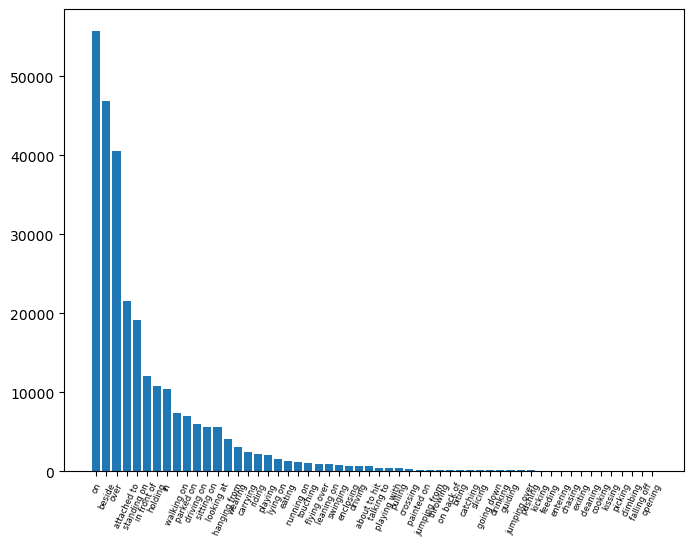

In [12]:
import collections
import matplotlib.pyplot as plt
dict_rels_cnt = dict(zip(json_data["predicate_classes"], rels_cnt))

sort_dict_rels_cnt = sorted(dict_rels_cnt.items(), key=lambda x:x[1], reverse=True)
sort_dict_rels_cnt = dict(sort_dict_rels_cnt)
sort_dict_rels_cnt
plt.figure(figsize=(8,6))
plt.bar(sort_dict_rels_cnt.keys(), sort_dict_rels_cnt.values())
x = list(sort_dict_rels_cnt.keys())
plt.xticks(x, fontsize=6, rotation=65)
plt.show()

# Split dataset into train & test

In [13]:
# Utilize same test images in openPSG

set_test_idx = set(json_data["test_image_ids"])

train_data = []
test_data = []

for d in json_data["data"]:
    if d['image_id'] not in set_test_idx:
        train_data.append(d)
    else:
        test_data.append(d)
print(len(train_data), len(test_data))

46563 2186


In [27]:
import numpy as np

def calc_dist(data):
    data = np.array(data)
    return data/(sum(data)+0.001)

def count_predicate(data):
    rels_cnt = [0]*56
    for img in data:
        for rel in img['relations']:
            rels_cnt[rel[2]] += 1
    
#     zipped = zip(json_data["predicate_classes"], rels_cnt)
#     res = sorted(zipped, key = operator.itemgetter(1), reverse=True)
    
    return rels_cnt

# Functions to split data

N은 the number of client를 의미하고
Eq or Neq는 사용자가 가지는 data의 개수가 동일한지 아니면 다른지를 의미합니다.

In [28]:
from random import shuffle
import os

train_dist = calc_dist(count_predicate(train_data))

def split_eq_size(N=10):
    with open('./psg/psg.json') as json_file:
        json_data = json.load(json_file)

    # fl_dataset에 폴더를 만들고 그 안에 각 client가 어떤 data를 가질지에 대한 json file을 저장합니다.
    
    folder = f'/data/fl_dataset/coco/TotC{N}_EqNum'  # 경로 수정
    # folder = f'./fl_dataset/coco/TotC{N}_EqNum'
    os.makedirs(folder, exist_ok=True)

    N_data = len(train_data)
    num_data = N_data // N

    shuffle(train_data)
    sum_dist = 0

    for c_idx in range(N):
        s_idx, e_idx = num_data * c_idx, num_data*(c_idx+1)
        json_data['data'] = train_data[s_idx: e_idx]

    #     file_path = os.path.join(folder, f'data_C{c_idx}_TotC{N}_EqNum.json')
    #     with open(file_path, 'w') as outfile:
    #         json.dump(json_data, outfile)

        tmp = calc_dist(count_predicate(train_data[s_idx: e_idx]))
        sum_dist += sum(abs(train_dist - tmp))

    print(f"Avg. TV distance: {sum_dist/N} \
        \n The number of data per client: {num_data} \
        \n Total number of client: {N}")
    
def split_neq_size(N=10):
    with open('./psg/psg.json') as json_file:
        json_data = json.load(json_file)

    folder = f'./fl_dataset/coco/TotC{N}_NeqNum'
    os.makedirs(folder, exist_ok=True)

    N_data = len(train_data)
    num_data = N_data // N

    c = np.random.rand(N)
    c = np.divide(c, sum(c))# c/sum(c)
    N_data = len(train_data)
    nums_data = N_data*c
    s_idx = 0

    shuffle(train_data)
    sum_dist = 0

    for c_idx in range(N):
        e_idx = s_idx + int(nums_data[c_idx])
        json_data['data'] = train_data[s_idx: e_idx]

#         file_path = os.path.join(folder, f'data_C{c_idx}_TotC{N}_NEqNum.json')
#         with open(file_path, 'w') as outfile:
#             json.dump(json_data, outfile)

        tmp = calc_dist(count_predicate(train_data[s_idx: e_idx]))
        sum_dist += sum(abs(train_dist - tmp))
        s_idx = e_idx

    print(f"Avg. TV distance: {sum_dist/N} \
        \n The number of data per client: {num_data} \
        \n Total number of client: {N}")

## Client 10

In [25]:
# Client: 10, Equal size
split_eq_size(10)
# Client: 10, Not Equal size
split_neq_size(10)

Avg. TV distance: 0.027550876209705         
 The number of data per client: 4656         
 Total number of client: 10
Avg. TV distance: 0.031023463719271966         
 The number of data per client: 4656         
 Total number of client: 10


## Client 100

In [19]:
# Client: 100, Equal size
split_eq_size(100)
# Client: 100, Not Equal size
split_neq_size(100)

Avg. TV distance: 0.09516371040360529         
 The number of data per client: 465         
 Total number of client: 100
Avg. TV distance: 0.13526466224503575         
 The number of data per client: 465         
 Total number of client: 100


## Client 500

In [29]:
# Client: 500, Equal size
split_eq_size(500)
# Client: 500, Not Equal size
split_neq_size(500)

Avg. TV distance: 0.21026359325197103         
 The number of data per client: 93         
 Total number of client: 500
Avg. TV distance: 0.2665192806708543         
 The number of data per client: 93         
 Total number of client: 500


# End data split

## Make non-IID with predicates

In [82]:
import os
with open('./data/psg/psg.json') as json_file:
    json_data = json.load(json_file)


def split_noniid_clustering(train_rels, C=10, N=100):
    if N%C != 0:
        raise ValueError("# of client must be divided by the # of cluster")
        
    # fl_dataset에 폴더를 만들고 그 안에 각 client가 어떤 data를 가질지에 대한 json file을 저장합니다.
    
    kmeans = KMeans(n_clusters=C)
    label = kmeans.fit_predict(train_rels)
    
    folder = f'/data/fl_dataset/coco/TotCluster{C}_TotUser{N}'  # 경로 수정
    # folder = f'./fl_dataset/coco/TotC{N}_EqNum'
    if os.path.isdir(folder):
        raise ValueError("Folder already exists")
    else:
        os.makedirs(folder)

    u_labels = np.unique(label)
    for i in u_labels:
        print(np.where(label == i)[0].shape)

        cluster_idx = np.where(label == i)[0]    
        shuffle(cluster_idx)

        splited_idxs = np.array_split(cluster_idx, N//C)

        for idx, splited_idx in enumerate(splited_idxs):
            json_data['data'] = list(np.array(train_data)[splited_idx])

            file_path = os.path.join(folder, f'data_Cluster{i}_User{idx}.json')
            with open(file_path, 'w') as outfile:
                json.dump(json_data, outfile)

In [85]:
img

{'file_name': 'train2017/000000180197.jpg',
 'height': 480,
 'width': 640,
 'image_id': '713945',
 'pan_seg_file_name': 'panoptic_train2017/000000180197.png',
 'segments_info': [{'id': 1511456,
   'category_id': 0,
   'iscrowd': 0,
   'isthing': 1,
   'attribute_ids': [],
   'gqa_category_id': 1084,
   'area': 1989},
  {'id': 2301222,
   'category_id': 0,
   'iscrowd': 0,
   'isthing': 1,
   'attribute_ids': [],
   'gqa_category_id': 1084,
   'area': 1309},
  {'id': 1971747,
   'category_id': 0,
   'iscrowd': 0,
   'isthing': 1,
   'attribute_ids': [],
   'gqa_category_id': 1084,
   'area': 1882},
  {'id': 3550269,
   'category_id': 0,
   'iscrowd': 0,
   'isthing': 1,
   'attribute_ids': [],
   'gqa_category_id': 868,
   'area': 17284},
  {'id': 2103327,
   'category_id': 0,
   'iscrowd': 0,
   'isthing': 1,
   'attribute_ids': [],
   'gqa_category_id': 1084,
   'area': 3322},
  {'id': 5786187,
   'category_id': 0,
   'iscrowd': 0,
   'isthing': 1,
   'attribute_ids': [],
   'gqa_cate

In [83]:
import json

with open('/home/SGG_FL/data/psg/psg.json') as json_file:
    json_data = json.load(json_file)

set_test_idx = set(json_data["test_image_ids"])

train_data = []
test_data = []

for d in json_data["data"]:
    if d['image_id'] not in set_test_idx:
        train_data.append(d)
    else:
        test_data.append(d)

train_rels = []

for idx, img in enumerate(train_data):
    rels = img['relations']
    ls_rels = [0]*56
    for rel in rels:
        # ls_rels[rel[2]] += 1
        ls_rels[rel[2]] = 1
    train_rels.append(ls_rels)

/home/SGG_FL/.conda/envs/hilo/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(6678,)
(8116,)
(5463,)
(3730,)
(4024,)
(2815,)
(4232,)
(3331,)
(2585,)
(5589,)


In [84]:
# 만들었기 때문에, 주석처리 함.

# split_noniid_clustering(train_rels, C=10, N=100)
# split_noniid_clustering(train_rels, C=20, N=100)

/home/SGG_FL/.conda/envs/hilo/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(907,)
(2911,)
(3944,)
(2902,)
(2965,)
(1500,)
(2588,)
(2396,)
(1466,)
(1719,)
(3406,)
(1878,)
(4740,)
(2455,)
(1029,)
(1934,)
(2257,)
(2620,)
(1398,)
(1548,)


## Make non-IID with Objects

In [103]:
import json

with open('/home/SGG_FL/data/psg/psg.json') as json_file:
    json_data = json.load(json_file)

set_test_idx = set(json_data["test_image_ids"])

train_data = []
test_data = []

for d in json_data["data"]:
    if d['image_id'] not in set_test_idx:
        train_data.append(d)
    else:
        test_data.append(d)

train_objs = []
# objects = dict()
# sorted(list(objects.keys()))
for idx, img in enumerate(train_data):
    info = img['segments_info']
    objects = [0]*133
    
    for img_info in info:
        objects[img_info['category_id']] += 1
        # objects[img_info['category_id']] = 1
    train_objs.append(objects)
# train_objs

/home/SGG_FL/.conda/envs/hilo/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


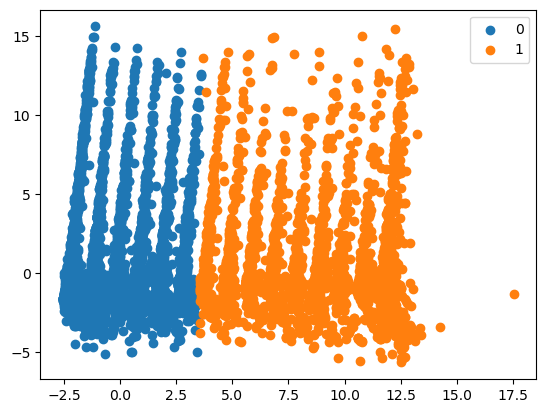

In [101]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn.neighbors import KNeighborsClassifier
import numpy as np
 
#Load Data
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(train_objs)

#Import required module
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#Initialize the class object
kmeans = KMeans(n_clusters= 2)

#predict the labels of clusters.
label = kmeans.fit_predict(df)
# label = kmeans.fit_predict(train_rels)

#Getting unique labels

u_labels = np.unique(label)

for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [104]:
import os
with open('./data/psg/psg.json') as json_file:
    json_data = json.load(json_file)

def split_noniid_clustering_objects(train_objects, C=10, N=100):
    if N%C != 0:
        raise ValueError("# of client must be divided by the # of cluster")
        
    # fl_dataset에 폴더를 만들고 그 안에 각 client가 어떤 data를 가질지에 대한 json file을 저장합니다.
    
    kmeans = KMeans(n_clusters=C)
    label = kmeans.fit_predict(train_objects)
    
    folder = f'/data/fl_dataset/coco/Objects_TotCluster{C}_TotUser{N}'  # 경로 수정
    # folder = f'./fl_dataset/coco/TotC{N}_EqNum'
    if os.path.isdir(folder):
        raise ValueError("Folder already exists")
    else:
        os.makedirs(folder)

    u_labels = np.unique(label)
    for i in u_labels:
        print(np.where(label == i)[0].shape)

        cluster_idx = np.where(label == i)[0]    
        shuffle(cluster_idx)

        splited_idxs = np.array_split(cluster_idx, N//C)

        for idx, splited_idx in enumerate(splited_idxs):
            json_data['data'] = list(np.array(train_data)[splited_idx])

            file_path = os.path.join(folder, f'data_Cluster{i}_User{idx}.json')
            with open(file_path, 'w') as outfile:
                json.dump(json_data, outfile)

In [105]:
split_noniid_clustering_objects(train_objs, 10, 100)

/home/SGG_FL/.conda/envs/hilo/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(527,)
(3503,)
(483,)
(7507,)
(441,)
(29151,)
(1253,)
(160,)
(260,)
(3278,)


In [106]:
split_noniid_clustering_objects(train_objs, 20, 100)

/home/SGG_FL/.conda/envs/hilo/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(4955,)
(15646,)
(395,)
(2350,)
(15857,)
(71,)
(238,)
(252,)
(452,)
(1328,)
(434,)
(168,)
(256,)
(819,)
(187,)
(189,)
(366,)
(183,)
(2190,)
(227,)
